## **PACKAGES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForTokenClassification

D:\Anaconda\envs\tensor\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **PRE-PROCESSING**

 **1. POSITIONAL ENCODING**

We feed our data into the model all at once when we train a Transformer network with multi-head attention. While this significantly decreases training time, no information regarding the arrangement of our data is provided. This is where positional encoding comes in handy; we can encode the positions of our inputs and transfer them into the network using the sine and cosine formulas:
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}$$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $k$ refers to each of the different dimensions in the positional encodings, with $i$ equal to $k$ $//$ $2$.

In [2]:
def angles(pos,k,d):
    i = k//2
    angle = np.divide(pos,10000 ** np.divide(2*i,d))
    return angle

In [3]:
def pos_encoding(max_pos_en, d):
    
    # Initializing a matrix for all the angles
    angle_r = angles(np.arange(max_pos_en)[:, np.newaxis], # (max_pos_en, 1)
                     np.arange(d)[np.newaxis,:], # (d,1)
                     d)
    # Applying sin to even indices in the array -> 2i
    angle_r[:, 0::2] = np.sin(angle_r[:, 0::2])
    
    # Applying cos to odd indices in the array -> 2i + 1
    angle_r[:, 1::2] = np.cos(angle_r[:, 1::2])
    
    # Inserting a new axis at position 0 while keeping the rest intact
    pos_en = angle_r[np.newaxis,...]
    
    return tf.cast(pos_en,dtype = tf.float32)

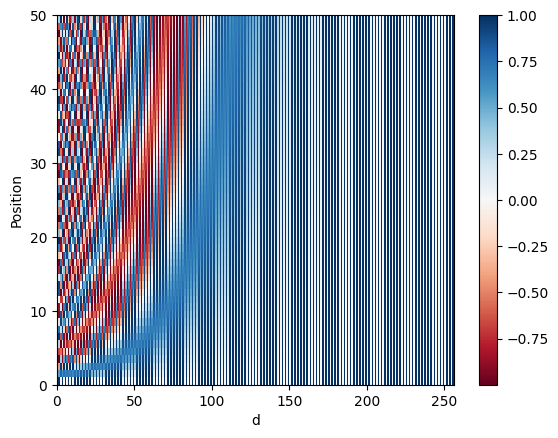

In [4]:
# Visualizing the positional encodings
p_e = pos_encoding(50,256)

plt.pcolormesh(p_e[0],cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 256))
plt.ylabel('Position')
# indicates the mapping between colors and values in the plot.
plt.colorbar()
plt.show()
# Each row represents a positional encoding 

**2. MASKING**

There are two types of masks that are useful when building the transformer network:

* Padding Mask = When passing sequences into the transformer model it is important that they must be uniform length. This can be achieved by truncating the sequences excedding the length and paddding the sequences with smaller size than the max with zeros. However, these zeros will affect the softmax calculation and this is where the padding mask comes in play. We will need to define a boolean mask that specifies to which elements we must attend(1) and which elements we must ignore(0). Later we will use that mask to set all the zeros in the sequence to a value close to negative infinity (-1e9). 

After masking, our input should go from [7, 60, 0, 0, 0] to [7, 60, -1e9, -1e9, -1e9], so that when we take the softmax, the zeros don't affect the score. The mask created is for an already padded sequence. However, TensorFlow Tokenizer and Hugging Face Tokenizer, which internally handle padding (and truncating) the input sequence can be utilized.

* Look ahead Mask = The look-ahead mask helps our model pretend that it correctly predicted a part of the output and see if, without looking ahead, it can correctly predict the next output.

These masks help the softmax to give the appropriate weights to the words in our input sentence

In [5]:
def padding_mask(decoder_token_id):
    seq = 1 - tf.cast(tf.math.equal(decoder_token_id,0),tf.float32)
    # Adding an extra dimension to add the paddings
    return seq[:,np.newaxis,:]

If we multiply (1 - mask) by -1e9 and add it to the sample input sequences, the zeros are essentially set to negative infinity. 

In [6]:
def look_ahead_mask(seq_length):
    
    # tf.ones -> Creates a tensor of shape ((1,seq_length,seq_length))
    # -1 -> Represents the upper diagonal
    # 0 -> Represents the lower diagonal
    # Therefore, the result will be a lower triangular matrix where the upper part is filled with zeros.
    # The output of tf.linalg.band_part is a tensor of same dimesnion as the input but with the appropriate elements set to zero
    # as per the diagonal specifications
    
    mask = tf.linalg.band_part(tf.ones((1,seq_length,seq_length)),-1,0)
    return mask

**3. SELF ATTENTION**

$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{3}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode


In [7]:
def scaled_dot_attention(q,k,v,mask):
    
    qk_transpose = tf.matmul(a = q, b = k, transpose_b = True)
    dk = tf.cast(tf.shape(k)[-1], dtype = tf.float32)
    scaled = qk_transpose / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled += (1. - mask) * 1.0e9 
    
    at_weights = tf.keras.activations.softmax(scaled, axis = -1)
    
    output = tf.matmul(soft,v)
    
    return at_weights, output

## **ENCODER & DECODER**

<img src="encoder_layer.png" alt="Encoder" width="450"/>
<caption><center><font color='purple'><b>Encoder layer</font></center></caption>

In [8]:
# Feed forward neural network contains two Dense layers which we'll implement as the function
def feed_forward(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential({
            Dense(fully_connected_dim, activation = 'relu'),
            Dense(embedding_dim)
    })

In [9]:
class EncoderLayer(tf.keras.layers.Layer):
    
    def _init_(self, embedding_dim, num_heads,fully_connected_dim, dropout_rate = 0.1, layernorm_eps = 1e-6):
        
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(num_heads = num_heads, key_dim = embedding_dim, dropout = dropout_rate)
        self.ffnn = feed_forward(embedding_dim = embedding_dim, fully_connected_dim = fully_connected_dim)
        self.ln1 = LayerNormalization(epsilon = layernorm_eps)
        self.ln2 = LayerNormalization(epsilon = layernorm_eps)
        self.do = Dropout(dropout_rate)
    
    def call(self,x,training,mask):
        
        # x -> Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        # training -> Boolean, set to true to activate the training mode for dropout layers
        # mask -> Boolean mask to ensure that the padding is not treated as part of the input
        
        mha_out = self.mha(query = x,key = x, value = x, attention_mask = mask)
        skip_conn_1 = self.ln1(mha_out + x)
        ffnn_in = self.ffnn(skip_conn_1)
        ffnn_out = self.Dropout(ffnn_in, training)
        
        encoder_out = self.ln2(skip_conn_1 + ffnn_out)
        
        return encoder_out   

In [13]:
class Encoder(tf.keras.layers.Layer):
    
    def _init_(self,num_layers,embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
            maximum_position_encoding, dropout_rate = 0.1, layernorm_eps = 1e-6):
        super(Encoder, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = pos_encoding(maximum_position_encoding,self.embedding_dim)
        
        self.encoding_layers = [EncoderLayer(embedding_dim = self.embedding_dim,
                                            num_heads = num_heads,
                                            fully_connected_dim = fully_connected_dim,
                                            dropout_rate = dropout_rate,
                                            layernorm_eps = layernorm_eps)
                                            for _ in range(self.num_layers)]
        
        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        
        seq_length = tf.shape(x)[1]
        
        x = self.embedding(x)
        x *= np.sqrt(tf.cast(self.embedding_dim, dtype = tf.float32))
        x += self.pos_encoding[:,:seq_length,:]
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x = self.encoding_layers[i](x,training,mask)
        
        return x    

<img src="decoder_layer.png" alt="Encoder" width="350"/>
<caption><center><font color='purple'><b>Decoder layer</font></center></caption>


In [14]:
class DecoderLayer(tf.keras.layers.Layer):
    
    def _init_(self, embedding_dim,num_heads, fully_connected_dim, dropout_rate = 0.1, layernorm_eps = 1e-6):
        super(DecoderLayer, self)._init_()
        
        self.mha1 = MultiHeadAttention(num_heads = num_heads,
                                       key_dim = embedding_dim,
                                       dropout = dropout_rate)
        
        self.mha2 = MultiHeadAttention(num_heads = num_heads,
                                       key_dim = embedding_dim,
                                       dropout = dropout_rate)
        
        self.ffnn_d = feed_forward(embedding_dim = embedding_dim,
                                   fully_connected_dim = fully_connected_dim)
        
        self.layernorm1 = LayerNormalization(epsilon = layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon = layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon = layernorm_eps)
        
        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        
        mha1_out, att_weig_b1 = self.mha1(query = x,key = x,value = x, attention_mask = look_ahead_mask, 
                                          return_attention_scores = True)
        
        Q = self.layernorm1(x + mha1_out)
        
        mha2_out, att_weig_b2 = self.mha2(query = x, key = enc_output, value = enc_output, attention_mask = padding_mask,
                                         return_attention_scores = True)
        
        l2 = self.layernorm2(mha2_out + Q)
        
        ffnn_output = self.ffnn_d(l2)
        ffnn_output = self.dropout(ffnn_output, training = training)
        
        dec_layer_out = self.layernorm3(l2 + ffnn_output)
        
        return dec_layer_out, att_weig_b1, att_weig_b2         

In [12]:
class Decoder(tf.keras.layers.Layer):
    
    def _init_(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size, max_pos_encoding, 
                dropout_rate = 0.1, layernorm_eps = 1e-6):
        super(Decoder,self)._init_()
        
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = pos_encodinh(max_pos_encoding, self.embedding_dim)
        
        self.decode_l = [DecoderLayer(embedding_dim = self.embedding_dim,
                                      num_layers = num_layers,
                                      fully_connected_dim = fully_connected_dim,
                                      dropout_rate = dropout_rate,
                                      layernorm_eps = layernorm_eps)
                                      for _ in range(self.num_layers)]
        
        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        
        seq_length = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= np.sqrt(tf.cast(self.embedding_dim, dtype = tf.float32))
        x += self.pos_encoding[:,:seq_length,:]
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            
            x, a_b_1, a_b_2 = self.decode_l[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = a_b_1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = a_b_2
            
        return x, attention_weights

## **TRANSFORMER**

In [15]:
class Transformer(tf.keras.Model):
    
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        
        enc_output = self.encoder(input_sentence, mask = enc_padding_mask) 
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, look_ahead_mask = look_ahead_mask, padding_mask = dec_padding_mask)
        
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights